## Metric 2: Mean daily wildfire PM2.5 concentration on 10 days with highest PM2.5 concentration each year

In [23]:
import numpy as np
import numpy.ma as ma
import os
from datetime import datetime, timedelta 
import csv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as mcolors

In [24]:
current_directory = os.path.dirname(os.getcwd())

In [25]:
# Daily Averaged WFS PM2.5 data by Census Tract
relative_path = "Output/Data/Daily_Average_WFS_PM25_by_Census_Tract.csv"
grouped_data_path = os.path.join(current_directory, relative_path)
PM25_by_Tracts_WFS = pd.read_csv(grouped_data_path)

# Census Tracts Shapefile
relative_sf_path = "Raw_Data/Shapefiles/Tracts2020_MatchedExtent.shp"
grouped_data_CT_path = os.path.join(current_directory, relative_sf_path)
Tracts2020 = gpd.read_file(grouped_data_CT_path)
Tracts2020 = Tracts2020.to_crs(epsg=3338) # NAD AK Albers projection (better to project maps of AK only)

In [26]:
# Maps Output Folder Path
output_folder = os.path.join(current_directory, "Output")

In [27]:
# Assuming 'Date' column is in datetime format
PM25_by_Tracts_WFS['Date'] = pd.to_datetime(PM25_by_Tracts_WFS['Date'])
PM25_by_Tracts_WFS['Year'] = PM25_by_Tracts_WFS['Date'].dt.year

# Group the data by 'Year' and 'NAME'
grouped_data = PM25_by_Tracts_WFS.groupby(['Year', 'NAME'], group_keys=True)

# Define a function to keep only the top 10 rows for each group
def keep_top_10_rows(group):
    return group.nlargest(10, 'PM2.5')

# Apply the function to each group in the grouped DataFrame
top_10_per_group = grouped_data.apply(keep_top_10_rows)
top_10_per_group

# Reset the index to ensure a clean index before pivoting
top_10_per_group_reset = top_10_per_group.reset_index(drop=True)

# Group by 'NAME' and 'Year' and calculate the average of 'PM2.5'
grouped_average = top_10_per_group_reset.groupby(['NAME', 'Year'])['PM2.5'].mean()

# Reshape the data to the desired format
final_table = grouped_average.unstack()
WFS_M2 = final_table.reindex(columns=sorted(final_table.columns))

# Reset the index, making 'NAME' a regular column
WFS_M2_df = WFS_M2.reset_index()

# Calculate the average of the annual averages
average_of_annual_averages = WFS_M2_df.loc[:, 2003:2020].mean(axis=1)
average_of_annual_averages = average_of_annual_averages.round(3)
WFS_M2_df['Averaged Annual Averages'] = average_of_annual_averages
WFS_M2_df.head()

Year,NAME,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Averaged Annual Averages
0,Abbott Loop,3.673,18.435,19.068,2.451,3.063,3.989,15.976,3.396,3.828,2.883,5.803,21.482,11.148,3.827,4.283,2.563,51.321,2.716,9.995
1,Abbott Loop North,3.673,18.435,19.068,2.451,3.063,3.989,15.976,3.396,3.828,2.883,5.803,21.482,11.148,3.827,4.283,2.563,51.321,2.716,9.995
2,Abbott Loop West,3.673,18.435,19.068,2.451,3.063,3.989,15.976,3.396,3.828,2.883,5.803,21.482,11.148,3.827,4.283,2.563,51.321,2.716,9.995
3,Airport Heights,3.673,18.435,19.068,2.451,3.063,3.989,15.976,3.396,3.828,2.883,5.803,21.482,11.148,3.827,4.283,2.563,51.321,2.716,9.995
4,Airport Way Central,22.161,369.584,54.760,17.839,6.104,6.356,98.254,23.941,21.844,11.302,30.543,7.284,83.982,5.456,11.660,14.918,87.599,3.971,48.753


In [28]:
max_values = WFS_M2.max(axis=0)
vmax = max(max_values)
vmax

369.584

In [29]:
# Save the DataFrames to CSV files
final_data_relative_path = "Output/Data/average_daily_wfs_pm25_10_smokiest_days.csv"
final_data_path = os.path.join(current_directory, final_data_relative_path)
WFS_M2_df.to_csv(final_data_path, index=False)

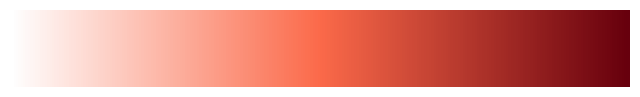

In [30]:
# Define colors: White -> Bright Red -> Deep Dark Red
colors = ["white", "#FB6A4A", "#67000D"]  # Bright red (#FB6A4A) from Reds at ~midpoint
WhiteToRed = mcolors.LinearSegmentedColormap.from_list("WhiteToBrightToDarkRed", colors)

# Test colormap with a gradient
gradient = np.linspace(0, 1, 256).reshape(1, -1)

fig, ax = plt.subplots(figsize=(8, 1))
ax.imshow(gradient, aspect="auto", cmap=WhiteToRed)
ax.set_axis_off()
plt.show()

# Panel Map

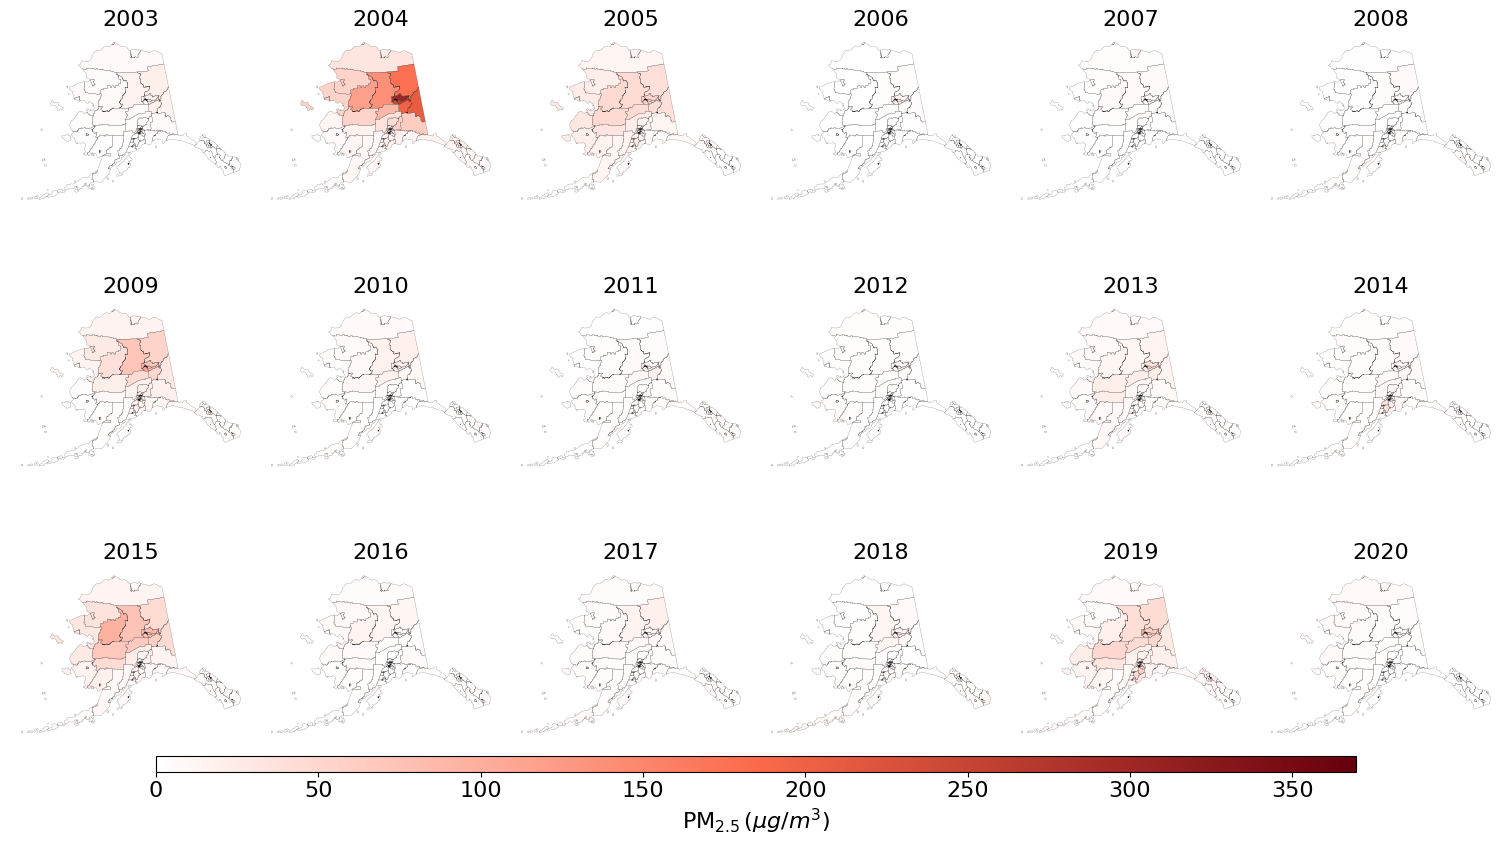

In [31]:
# Set the number of rows and columns for the panel
num_rows = 3
num_cols = 6

# Round the specified columns and convert to integer
columns_to_round = WFS_M2.columns.difference(['NAME'])
WFS_M2[columns_to_round] = WFS_M2[columns_to_round].round(2).astype(int)

# Create a figure and GeoAxes with the Albers Equal Area projection
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
fig, axes = plt.subplots(num_rows, num_cols, subplot_kw={'projection': alaska_albers}, figsize=(15, 8), constrained_layout=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Round all columns 
WFS_M2 = WFS_M2.round()

# Iterate over each year
for i, year in enumerate(WFS_M2.columns):
    # Merge shapefile with the corresponding data for the current year
    merged_data = Tracts2020.merge(pd.DataFrame({'NAME': WFS_M2.index, 'Avg_PM25': WFS_M2[year].values}), on='NAME', how='inner')

    # Add thin black border to the shapefile data
    merged_data.boundary.plot(ax=axes[i], color='black', linewidth=0.10, transform=alaska_albers)
    vmin = 0

    # Plot the shapefile with color based on Average_PM25 values
    merged_data.plot(ax=axes[i], column='Avg_PM25', cmap=WhiteToRed, transform=alaska_albers, legend=False, vmin=vmin, vmax=vmax, edgecolor='none', linewidth=0)

    # Set plot title
    axes[i].set_title(f"{year}", fontsize=16)

    # Remove axes ticks and labels
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])

    # Remove frame around each subplot
    axes[i].axis('off')
    
# Generate tick positions
ticks = np.arange(0, vmax + 50, 50)

# Generate a single colorbar for all plots
cbar_ax = fig.add_axes([0.1, 0.02, 0.8, 0.02])  # Adjust the width of the colorbar here
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=WhiteToRed),
                    cax=cbar_ax, orientation='horizontal', ticks=ticks)
cbar.set_label(r'$\mathrm{PM}_{2.5}\, (\mu g/m^3)$', fontsize=16)  # Increase title size
cbar_ax.tick_params(labelsize=16)  # Increase tick label size

# Draw the figure to ensure everything is properly rendered
plt.draw()

# Export
output_file_path = f"{output_folder}/Panel_Maps/average_daily_wfs_pm25_10_smokiest_days_Panel.png"
plt.savefig(output_file_path, dpi=600, bbox_inches='tight')
plt.show()

# Cumulative Map

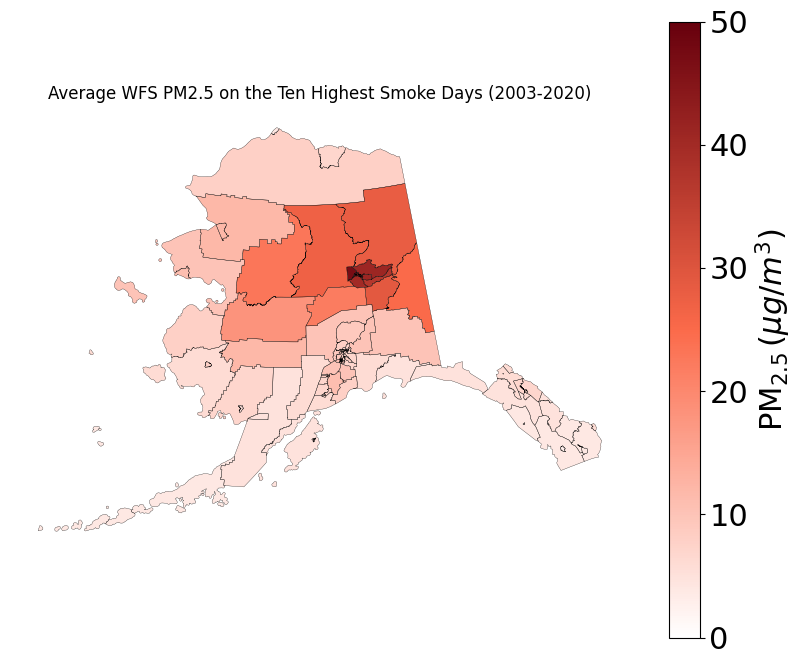

In [32]:
# Create a figure and GeoAxes with the Albers Equal Area projection
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
fig, ax = plt.subplots(subplot_kw={'projection': alaska_albers}, figsize=(10, 8))

# Merge the census data with the WFS_M1_Year_Tract DataFrame
WFS_M2_Cummul_Tract_wGeo = Tracts2020.merge(WFS_M2_df, on='NAME', how='inner')

# Variable handling
WFS_M2_Cummul_Tract_wGeo.columns = WFS_M2_Cummul_Tract_wGeo.columns.astype(str)

# Round
WFS_M2_Cummul_Tract_wGeo['Averaged Annual Averages'] = WFS_M2_Cummul_Tract_wGeo['Averaged Annual Averages'].round()

# Set vmin and vmax based on the '2003-2020' data
vmin = 0
vmax = WFS_M2_Cummul_Tract_wGeo['Averaged Annual Averages'].max()
vmax

# Plot the shapefile data with a custom legend title
WFS_M2_Cummul_Tract_wGeo.plot(
    ax=ax,
    column='Averaged Annual Averages',
    cmap=WhiteToRed,
    transform=alaska_albers,
    legend=True,
    vmin=vmin,
    vmax=vmax,
    legend_kwds={'label': r'$\mathrm{PM}_{2.5}\, (\mu g/m^3)$', 'orientation': "vertical"}
)

# Colorbar label text sizing
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel(r'$\mathrm{PM}_{2.5}\, (\mu g/m^3)$', fontsize=22)  # Increase title size
cbar.tick_params(labelsize=22)  # Increase tick label size

# Add thin black border to the shapefile data
WFS_M2_Cummul_Tract_wGeo.boundary.plot(ax=ax, color='black', linewidth=0.20, transform=alaska_albers)

# Remove box around map
fig, ax = plt.gcf(), plt.gca()
ax.axis('off')

# Export untitled map
output_file_path = f"{output_folder}/Cumulative_Maps/average_daily_wfs_pm25_10_smokiest_days_Cummulative.png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

# Map title
ax.set_title('Average WFS PM2.5 on the Ten Highest Smoke Days (2003-2020)')

# Draw the figure to ensure everything is properly rendered
plt.draw()

# Export titled map
output_file_path = f"{output_folder}/Cumulative_Maps/average_daily_wfs_pm25_10_smokiest_days_Cummulative_wTitle.png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

# Show the figure in the notebook
plt.show()

# Annual Maps

In [33]:
# Find min and max
years_to_plot = [year for year in WFS_M2.columns if year not in ['NAME']]
vmin=0
vmax = WFS_M2[years_to_plot].max().max()
vmax

369

In [34]:
# Iterate over each year in the DataFrame
for year in WFS_M2.columns:
    # Merge shapefile with the corresponding data for the current year
    merged_data = Tracts2020.merge(
        pd.DataFrame({'NAME': WFS_M2.index, 'Avg_PM25': WFS_M2[year].values}),
        on='NAME', how='inner'
    )

    # Create a figure and GeoAxes with the Albers Equal Area projection
    alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
    fig, ax = plt.subplots(subplot_kw={'projection': alaska_albers}, figsize=(10, 8))

    # Add thin black border to the shapefile data
    merged_data.boundary.plot(ax=ax, color='black', linewidth=0.20, transform=alaska_albers)

    # Plot the shapefile with color based on Average_PM25 values
    merged_data.plot(
        ax=ax, column='Avg_PM25', cmap=WhiteToRed, transform=alaska_albers,
        legend=False, edgecolor='none', linewidth=0
    )

    # Set plot title
    ax.set_title(f"WFS M2: PM2.5 for Top Highest Smoke Days in Each Census Tract for {year}")

    # Remove axes ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')

    # Generate tick positions for the colorbar
    ticks = np.arange(0, vmax + 50, 50)

    # Generate a colorbar **inside** the loop
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # Adjust colorbar position
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=WhiteToRed),
        cax=cbar_ax, orientation='horizontal', ticks=ticks
    )
    cbar.set_label(r'$\mathrm{PM}_{2.5}\, (\mu g/m^3)$')

    # Save the output image for the current year
    output_file_path = f"{output_folder}/Annual_Maps/average_daily_wfs_pm25_10_smokiest_days_AQI_{year}.png"
    plt.savefig(output_file_path, dpi=600, bbox_inches='tight')  # Ensure tight layout
    plt.close(fig)

# Panel Map with AQI categories

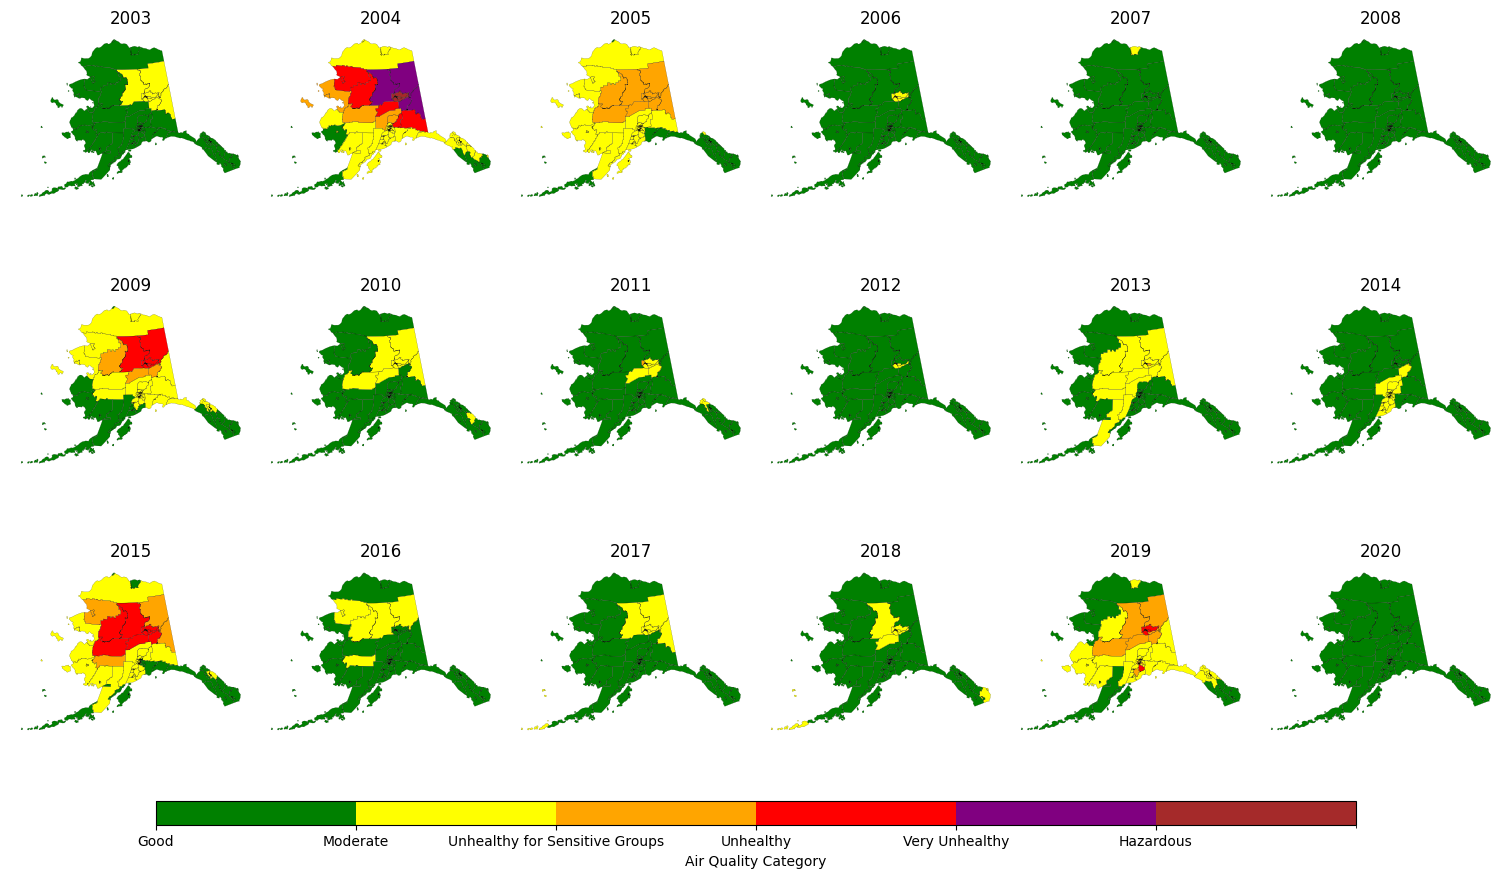

In [38]:
# AQI Colors and Category Names
colors = ['green', 'yellow', 'orange', 'red', 'purple', 'brown']
bounds = [0.0, 9.0, 35.4, 55.4, 125.4, 225.4, 500]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
aqi_categories = ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy", "Hazardous"]

# Create a figure and GeoAxes with the Albers Equal Area projection
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
fig, axes = plt.subplots(num_rows, num_cols, subplot_kw={'projection': alaska_albers}, figsize=(15, 8), constrained_layout=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over each year
for i, year in enumerate(WFS_M2.columns):
    # Merge shapefile with the corresponding data for the current year
    merged_data = Tracts2020.merge(pd.DataFrame({'NAME': WFS_M2.index, 'Avg_PM25': WFS_M2[year].values}), on='NAME', how='inner')

    # Add thin black border to the shapefile data
    merged_data.boundary.plot(ax=axes[i], color='black', linewidth=0.10, transform=alaska_albers)
    vmin = 0

    # Plot the shapefile with color based on Average_PM25 values
    merged_data.plot(ax=axes[i], column='Avg_PM25', cmap=cmap, norm=norm, transform=alaska_albers, legend=False, edgecolor='none', linewidth=0)

    # Set plot title
    axes[i].set_title(f"{year}")

    # Remove axes ticks and labels
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
    axes[i].set_frame_on(False)

# Add a single horizontal colorbar at the bottom
cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.03])  # Adjust the position and size as needed
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')

# Set the colorbar label and custom tick labels
cbar.set_label('Air Quality Category')
cbar.set_ticks(bounds[:-1])  # Set ticks at each AQI category boundary
cbar.set_ticklabels(aqi_categories)  # Set the AQI category labels

# Draw the figure to ensure everything is properly rendered
plt.draw()
    
# Save the panel image
output_file_path = f"{output_folder}/Panel_Maps/average_daily_wfs_pm25_10_smokiest_days_AQI_Panel.png"
plt.savefig(output_file_path, dpi=600, bbox_inches='tight')

plt.show()

# Annual Maps with AQI categories

In [36]:
# Iterate over each year in the DataFrame
for year in WFS_M2.columns:
    # Merge shapefile with the corresponding data for the current year
    merged_data = Tracts2020.merge(
        pd.DataFrame({'NAME': WFS_M2.index, 'Avg_PM25': WFS_M2[year].values}),
        on='NAME', how='inner'
    )

    # Create a figure and GeoAxes with the Albers Equal Area projection
    alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
    fig, ax = plt.subplots(subplot_kw={'projection': alaska_albers}, figsize=(10, 8))

    # Add thin black border to the shapefile data
    merged_data.boundary.plot(ax=ax, color='black', linewidth=0.10, transform=alaska_albers)

    # Plot the shapefile with color based on Average_PM25 values
    merged_data.plot(
        ax=ax, column='Avg_PM25', cmap=cmap, norm=norm, transform=alaska_albers,
        legend=False, edgecolor='none', linewidth=0
    )

    # Set plot title
    ax.set_title(f"PM2.5 AQI for Top Highest Smoke Days in Each Census Tract for {year}")

    # Remove axes ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

    # Add a horizontal colorbar below the map
    cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.03])
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax, orientation='horizontal'
    )

    # Set the colorbar label and custom tick labels
    cbar.set_label('Air Quality Category')
    cbar.set_ticks(bounds[:-1])
    cbar.set_ticklabels(aqi_categories)

    # Save the output image for the current year
    output_file_path = f"{output_folder}/Annual_Maps/average_daily_wfs_pm25_10_smokiest_days_Annual_AQI_{year}.png"
    plt.savefig(output_file_path, dpi=600)
    plt.close()

# Cumulative Map with AQI categories

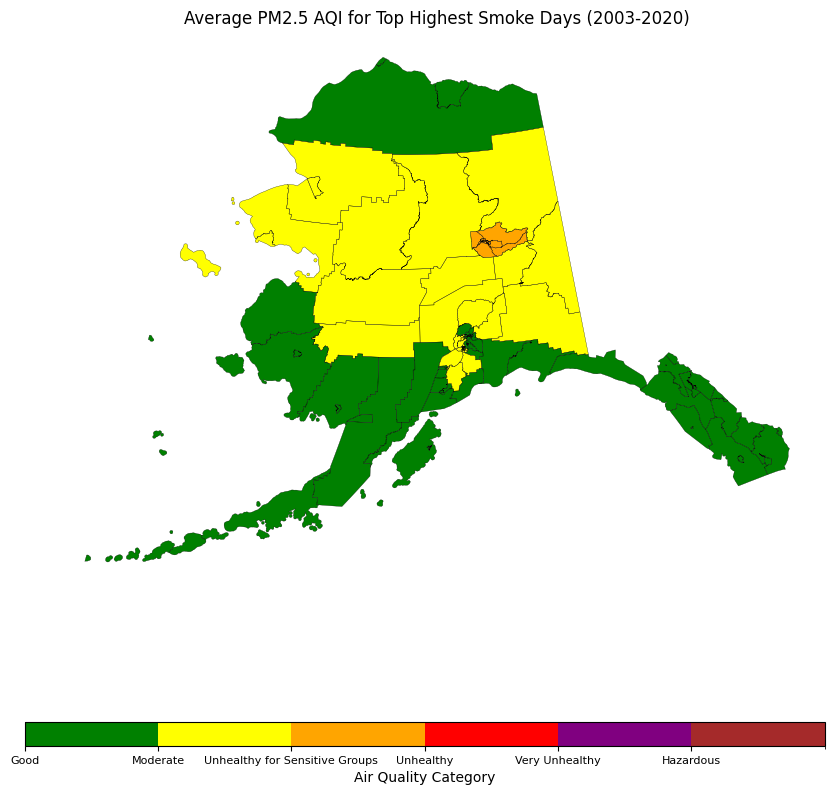

In [37]:
# Create a figure and GeoAxes with the Albers Equal Area projection
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
fig, ax = plt.subplots(subplot_kw={'projection': alaska_albers}, figsize=(10, 8))

# Plot tract boundaries
WFS_M2_Cummul_Tract_wGeo.boundary.plot(ax=ax, color='black', linewidth=0.2, transform=alaska_albers)

# Plot filled tracts with AQI categories
WFS_M2_Cummul_Tract_wGeo.plot(
    ax=ax,
    column='Averaged Annual Averages',
    cmap=cmap,
    norm=norm,
    transform=alaska_albers,
    legend=False,
    edgecolor='none'
)

# Set map title and remove axes
ax.set_title('AQI Category Based on Average WFS PM₂.₅ (Top 10 Days, 2003–2020)', fontsize=16)
ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])

# Add horizontal colorbar below the map
cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax,
    orientation='horizontal'
)

# Configure colorbar
cbar.set_label('Air Quality Category')
cbar.set_ticks(bounds[:-1])
cbar.set_ticklabels(aqi_categories)
cbar.ax.tick_params(labelsize=8)

# Export untitled map
output_file_path = f"{output_folder}/Cumulative_Maps/average_daily_wfs_pm25_10_smokiest_days_AQI_Cummulative.png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

# Map title
ax.set_title('Average PM2.5 AQI for Top Highest Smoke Days (2003-2020)')

# Draw the figure to ensure everything is properly rendered
plt.draw()

# Export titled map
output_file_path = f"{output_folder}/Cumulative_Maps/average_daily_wfs_pm25_10_smokiest_days_Cummulative_AQI_wTitle.png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

plt.show()
plt.close()